# Infancias, vegetación y proximidad

This notebook plots population of the ages 0-5 (early childhood), NDVI vegetation categories and proximity analysis for a city.

In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pandas.api.types import CategoricalDtype

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/usr/local/python/lib/python3.10/site-packages/osmnx/utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


## Config notebook

In [12]:
# City of analysis
city = 'Aguascalientes'

# Resolution of analysis
# (Resolutions 8,9,10,11 available for NDVI but pop0a5 only available in hex_bins_pop_2020, res=8)
res = 8
#! Name of proximity analysis table must be changed manually.

# Save output plots?
save = False
save_dir = "../../../output/figures/ndvi_infancia/"

## Download data

### Download data - Proximity analysis

In [3]:
prox_schema = 'prox_analysis'
prox_table = 'proximityanalysis_20_ageb_hex8'

query = f"SELECT * FROM {prox_schema}.{prox_table} WHERE \"city\" LIKE \'{city}\'"
prox_gdf = aup.gdf_from_query(query, geometry_col='geometry')

# Show
print(prox_gdf.shape)
prox_gdf.head(2)

(309, 34)


,hex_id,res,geometry,max_escuelas,max_preescolar,max_primaria,max_secundaria,max_servicios comunitarios,max_salud,max_guarderías,...,pobmas,pob_0a2,pob_3a5,pob_0a5,pob_0a14,pob_15a24,pob_25a59,p_60ymas,dens_pobha,city
0,88498e36dbfffff,8,"POLYGON ((-102.34777 21.92336, -102.34267 21.9...",15.057619,13.586498,15.057619,11.969535,62.167866,53.640209,50.912589,...,133.03125,15.806251,16.762499,32.56875,75.937500,50.962500,117.731249,20.081251,3.063433,Aguascalientes
1,88498e36d5fffff,8,"POLYGON ((-102.32839 21.92505, -102.32329 21.9...",41.764955,22.511213,23.594408,41.764955,49.597804,49.597804,23.166648,...,498.61400,16.727587,27.813663,44.54125,142.968993,171.018986,497.508140,228.414930,12.047757,Aguascalientes


### Download data - NDVI Data

In [4]:
ndvi_schema = 'raster_analysis'
ndvi_table = 'ndvi_analysis_hex'

query = f"SELECT * FROM {ndvi_schema}.{ndvi_table} WHERE \"city\" LIKE \'{city}\' AND \"res\"={res}"
ndvi_gdf = aup.gdf_from_query(query, geometry_col='geometry')

# Show
print(ndvi_gdf.shape)
ndvi_gdf.head(2)

(309, 11)


,hex_id,geometry,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,city
0,884988cb01fffff,"POLYGON ((-102.34411 21.98667, -102.34461 21.9...",8,0.243300,0.140056,0.186875,0.475187,0.117063,0.358124,-0.001412,Aguascalientes
1,884988cb05fffff,"POLYGON ((-102.34411 21.98667, -102.33901 21.9...",8,0.113469,0.047483,0.098750,0.187818,0.073517,0.114301,-0.001012,Aguascalientes


### Download data - 2020 Census data 

In [5]:
mun_schema = 'metropolis'
mun_table = 'metro_gdf'

query = f"SELECT * FROM {mun_schema}.{mun_table} WHERE \"city\" LIKE \'{city}\'"
mun_gdf = aup.gdf_from_query(query, geometry_col='geometry')

# Show
print(mun_gdf.shape)
mun_gdf.head(2)

(3, 6)


,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,geometry,city
0,01001,01,001,Aguascalientes,"POLYGON ((-102.10641 22.06035, -102.10368 22.0...",Aguascalientes
1,01005,01,005,Jesús María,"POLYGON ((-102.33568 22.05067, -102.33348 22.0...",Aguascalientes


In [6]:
# Get cvegeos of city
cvegeo_list = list(mun_gdf.loc[mun_gdf.city==city]["CVEGEO"].unique())

# Donwload hexagons with pop data
hex_pop = gpd.GeoDataFrame()
hex_schema = 'censo'
hex_table = 'hex_bins_pop_2020'

# Iterate over municipality codes for each metropolitan area or capital
for cvegeo in cvegeo_list:
    # Downloads municipality polygon according to code
    query = f"SELECT * FROM {hex_schema}.{hex_table} WHERE \"CVEGEO\" LIKE \'{cvegeo}%%\'"
    hex_tmp = aup.gdf_from_query(query, geometry_col='geometry')
    hex_pop = pd.concat([hex_pop, hex_tmp],
    ignore_index = True, axis = 0)
    
# Show
print(hex_pop.shape)
hex_pop.head(2)

(309, 225)


,geometry,hex_id_8,CVEGEO,pobtot,pobfem,pobmas,p_0a2,p_0a2_f,p_0a2_m,p_3ymas,...,vph_telef,vph_cel,vph_inter,vph_stvp,vph_spmvpi,vph_cvj,vph_sinrtv,vph_sintlc,vph_sincint,vph_sintic
0,"POLYGON ((-102.34777 21.92336, -102.34267 21.9...",88498e36dbfffff,01001,264.7125,131.68126,133.03125,15.806251,7.650000,8.156250,248.90625,...,22.893751,57.26250,36.225002,25.53750,18.393751,14.51250,0.618750,2.7,21.993750,0.3375
1,"POLYGON ((-102.32839 21.92505, -102.32329 21.9...",88498e36d5fffff,01001,1040.9625,542.34850,498.61400,16.727587,7.983356,8.744229,1023.18360,...,276.779170,301.68845,298.401430,257.00134,238.801570,118.86585,0.537984,0.0,4.003337,0.0000


## Data treatment

### Data treatment - Early childhood % Calculation

<Axes: >

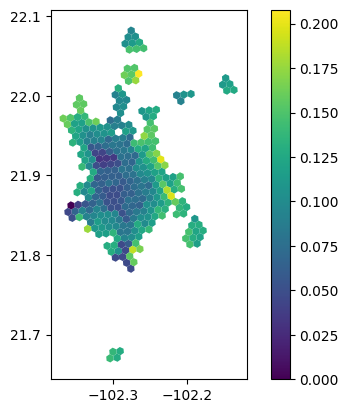

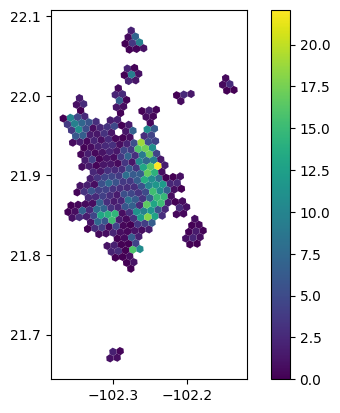

In [18]:
# Calculate % infancia
hex_pop['p_infancia'] = hex_pop['p_0a2'] + hex_pop['p_3a5']
hex_pop['pct_infancia'] = hex_pop['p_infancia'] / hex_pop['pobtot']

# Calculate childhood density
hex_pop.to_crs("EPSG:6372",inplace=True)
hex_pop['dens_pobha'] = hex_pop.p_infancia / (hex_pop.area / 10000)
hex_pop.to_crs("EPSG:4326",inplace=True)

# Show
hex_pop.plot('pct_infancia', legend=True)
hex_pop.plot('dens_pobha', legend=True)

### Data treatment - Childhood and NDVI Categories 

Early childhood categories

In [19]:
hex_pop['pct_inf_rango'] = np.nan
hex_pop.loc[hex_pop.pct_infancia>=0.14 , 'pct_inf_rango'] = '+14%'
hex_pop.loc[(hex_pop.pct_infancia>=0.12 )&
             (hex_pop.pct_infancia<0.14), 'pct_inf_rango'] = '12% - 14%'
hex_pop.loc[(hex_pop.pct_infancia>=0.10)&
             (hex_pop.pct_infancia<0.12), 'pct_inf_rango'] = '10% - 12%'
hex_pop.loc[(hex_pop.pct_infancia>=0.08)&
             (hex_pop.pct_infancia<0.1), 'pct_inf_rango'] = '8% - 10%'
hex_pop.loc[(hex_pop.pct_infancia>=0.06)&
             (hex_pop.pct_infancia<0.08), 'pct_inf_rango'] = '6% - 8%'
hex_pop.loc[(hex_pop.pct_infancia>=0.03)&
             (hex_pop.pct_infancia<0.06), 'pct_inf_rango'] = '3% - 6%'
hex_pop.loc[(hex_pop.pct_infancia<0.03), 'pct_inf_rango'] = '0% - 3%'

#Definir orden y convertir pct_inf_rango en categoría ordenada
categories = ['0% - 3%', '3% - 6%', '6% - 8%', '8% - 10%', '10% - 12%', '12% - 14%', '+14%']
hex_pop['pct_inf_rango'] = pd.Categorical(hex_pop['pct_inf_rango'], categories=categories, ordered=True)

NDVI categories

In [20]:
ndvi_gdf['ndvi_median_rango'] = np.nan
ndvi_gdf.loc[ndvi_gdf.ndvi_median>=0.6 , 'ndvi_median_rango'] = 'Alta densidad vegetal'
ndvi_gdf.loc[(ndvi_gdf.ndvi_median>=0.4 )&
             (ndvi_gdf.ndvi_median<0.6), 'ndvi_median_rango'] = 'Moderada densidad vegetal'
ndvi_gdf.loc[(ndvi_gdf.ndvi_median>=0.2)&
             (ndvi_gdf.ndvi_median<0.4), 'ndvi_median_rango'] = 'Mínima densidad vegetal'
ndvi_gdf.loc[(ndvi_gdf.ndvi_median>=0.1)&
             (ndvi_gdf.ndvi_median<0.2), 'ndvi_median_rango'] = 'Suelo'
ndvi_gdf.loc[(ndvi_gdf.ndvi_median<0.1), 'ndvi_median_rango'] = 'Suelo artificial/Agua/Piedra'


#Definir orden y convertir pct_inf_rango en categoría ordenada
categories = ['Suelo artificial/Agua/Piedra', 'Suelo', 'Mínima densidad vegetal', 'Moderada densidad vegetal', 'Alta densidad vegetal']
ndvi_gdf['ndvi_median_rango'] = pd.Categorical(ndvi_gdf['ndvi_median_rango'], categories=categories, ordered=True)

Proximity analysis categories

In [21]:
prox_gdf['prox_cat'] = np.nan
prox_gdf.loc[prox_gdf.max_idx_15_min>=60 , 'prox_cat'] = '>60'
prox_gdf.loc[(prox_gdf.max_idx_15_min>=45 )&
             (prox_gdf.max_idx_15_min<60), 'prox_cat'] = '45-60'
prox_gdf.loc[(prox_gdf.max_idx_15_min>=30)&
             (prox_gdf.max_idx_15_min<45), 'prox_cat'] = '30-45'
prox_gdf.loc[(prox_gdf.max_idx_15_min>=15)&
             (prox_gdf.max_idx_15_min<30), 'prox_cat'] = '15-30'
prox_gdf.loc[(prox_gdf.max_idx_15_min<15), 'prox_cat'] = '<15'


#Definir orden y convertir pct_inf_rango en categoría ordenada
categories = ['<15', '15-30', '30-45', '45-60', '>60']
prox_gdf['prox_cat'] = pd.Categorical(prox_gdf['prox_cat'], categories=categories, ordered=True)

### Data treatment - Filter analysis data

In [22]:
# Filter for ranges of interest
prox_interest_gdf = prox_gdf.loc[(prox_gdf['prox_cat'] == '<15') | 
                                 (prox_gdf['prox_cat'] == '15-30')]

#Refinir orden y de las categorías disponibles para que no haya problemas en la simbología al plotear
categories = ['15-30','<15']
prox_interest_gdf['prox_cat'] = pd.Categorical(prox_interest_gdf['prox_cat'], categories=categories, ordered=True)

# Dissolve data
prox_interest_gdf.to_crs("EPSG:6372",inplace=True)
dissolved = prox_interest_gdf.dissolve('prox_cat')
dissolved.reset_index(inplace=True)
dissolved.to_crs("EPSG:4326",inplace=True)

/usr/local/python/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


### Plot data visualization

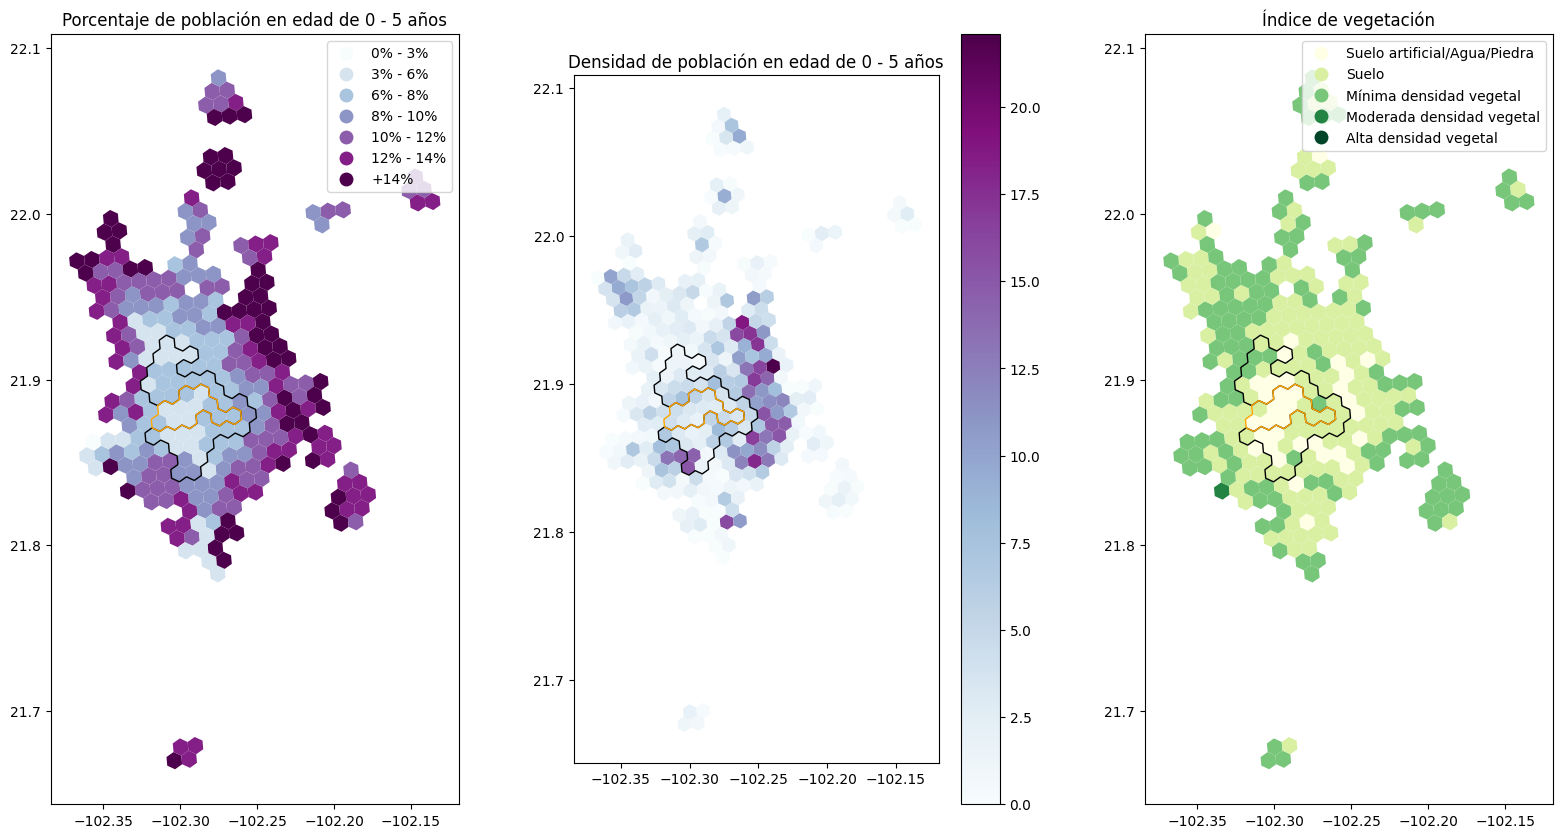

In [23]:
# Preparar colores
colors = ["black","orange"]

# Plotear gráficos
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
hex_pop.plot('pct_inf_rango', 'BuPu', ax=ax[0], legend=True,zorder=1)
dissolved.plot('prox_cat',ax=ax[0],zorder=2,
               edgecolor=colors,
               facecolor="none",
               lw=1)

hex_pop.plot('dens_pobha', 'BuPu', ax=ax[1], legend=True,zorder=1)
dissolved.plot('prox_cat',ax=ax[1],zorder=2,
               edgecolor=colors,
               facecolor="none",
               lw=1)

ndvi_gdf.plot('ndvi_median_rango','YlGn', ax=ax[2], legend=True,zorder=1)
dissolved.plot('prox_cat',ax=ax[2],zorder=2,
               edgecolor=colors,
               facecolor="none",
               lw=1)

ax[0].set_title('Porcentaje de población en edad de 0 - 5 años')
ax[1].set_title('Densidad de población en edad de 0 - 5 años')
ax[2].set_title('Índice de vegetación')

# Guardar gráficos
if save:
    plt.savefig(save_dir+f"ndvi_infancia_prox_{city.lower()}.svg")